In [1]:
import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer
from easydict import EasyDict as edict
import networkx as nx
import operator


In [2]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1"), 
                                 elementRes  = (96, 48), 
                                 minCoord    = (-1.0, 0.0), 
                                 maxCoord    = (1.0, 1.0) )


temperatureField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
velocityField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=2 )
coordinate = fn.input()


In [3]:
class szModel(object):
    def __init__(self, mesh,tField, vField):
        self.mesh = mesh
        self.temperatureField = tField
        self.velocityField = vField
        #basic coordinate fns
        coordinate = fn.input()
        self.xFn = coordinate[0]  #a function providing the x-coordinate
        self.yFn = coordinate[1]
        self.depthFn = self.mesh.maxCoord[1] - coordinate[1] #a function providing the depth
        #basic mesh variables
        


In [4]:
#szm = szModel(mesh,  temperatureField, velocityField)
#szm.mesh.minCoord[0]

## tectModel based on networkx

In [385]:
class TectModel(nx.DiGraph):
    
    
    def __init__(self, mesh, starttime, endtime, dt):
        
        ########Trying various ways to init the parent class
        #super(nx.DiGraph, self).__init__(*args)
        #super().__init__(*args) 
        nx.DiGraph.__init__(self) 
        ################################
        
        self.times = np.arange(starttime, endtime, dt)
        #self.add_node('times', times=self.times)
        self.plateIdUsedList = []
        self.plateIdDefaultList = list(np.arange(1, 101))
        
        #mesh and coordinate functions
        self.mesh = mesh
        self._coordinate = fn.input()
        self._xFn = self._coordinate[0]
    

    #using getters as I'm unsure how this part of the code may evolve,
    #i.e. the coupling between underworld objects and the current Class
    
    @property
    def xFn(self): 
        return self._xFn
    
    @property
    def minX(self): 
        return self.mesh.minCoord[0]
    
    @property
    def maxX(self): 
        return self.mesh.maxCoord[0]
    
    @property
    def undirected(self): 
        return self.to_undirected()
    
    
    
    ################################# 
    #Read from Dict function to allow checkpointing
    #################################  
    def pop_from_dict_of_lists(self, d):

        """Return a graph from a dictionary of lists.
        Adapted from the networkX function

        """

        self.add_nodes_from(d)
        self.add_edges_from(((u, v, data)
                              for u, nbrs in d.items()
                              for v, data in nbrs.items()))


    #################################        
    ##General graph query / utilities 
    ################################# 
    
    def connected_plates(self, plateId):
        
        #return (list(set([x for x in nx.all_neighbors(self, plateId)])))
        return self.undirected.neighbors(plateId)
        
    
    def is_subduction_boundary(self, plate1, plate2):
        result = False
        
        #possible options are: no connection between nodes (False, False)
        #           :  two way connecrion (ridge) (True, True)
        #           : one way connection (Truem False) ....
        
        if self.has_edge(plate1, plate2) != tg.has_edge(plate2, plate1):
            result = True            
        return result
        
    
    def is_subducting_plate(self, plateId):
        pass
    
    def has_self_loop(self, plateId):
        pass
    
    
    def get_boundaries(self, plateId):
        
        """
        Use the undirected graph
        """
        
        if len(self.connected_plates(plateId)) == 2:

            
            cps = self.connected_plates(plateId)
            #cps = self.undirected.neighbors(plateId)
            print(cps)
            loc1 = self.undirected[plateId][cps[0]]['loc']
            loc2 = self.undirected[plateId][cps[1]]['loc']   
            return [loc1, loc2]
                
        else:
            print('plate does not have 2 boundaries. Cannot define extent.')
            return []

    #################################     
    ##Adding plates / plate boundaries
    #################################   
    
    def add_plate(self, ID = False, velocities = []):
        if type(velocities) == int or type(velocities) == float:
            vels = np.ones(len(self.times ))*velocities
        elif len(velocities) == len(self.times ):
            vels = velocities
        elif len(velocities) != len(self.times ):
            raise ValueError("velocities must be a single float/int or list/array of length self.times ")
        
        
        if not ID:
            ID = self.plateIdDefaultList[0]
        
        if ID not in self.plateIdUsedList:
            self.add_node(ID, velocities= vels)
            self.plateIdUsedList.append(ID)
            self.plateIdDefaultList.remove(ID)
        else:
            raise ValueError("plate ID already assigned")
        
    def add_subzone(self, subPlate, upperPlate, loc, subInitAge=0.0, upperInitAge=0.0):
        
        #check whether the plate boundary can be simply inserted
        if len(self.connected_plates(subPlate)) <=2 and len(self.connected_plates(upperPlate)) <=2 : 

            self.add_edge(subPlate, upperPlate, 
                          loc= loc,
                          ages = {subPlate:subInitAge, 
                                  upperPlate:upperInitAge})
        else:
            print('plate already has 2 boundaries. Wait for plate transfer to be implemented')
        
    def add_ridge(self, plate1, plate2, loc, plate1InitAge=0.0, plate2InitAge=0.0):
        
        #check whether the plate boundary can be simply inserted
        if len(self.connected_plates(plate1)) <=2 and len(self.connected_plates(plate2)) <=2: 
            
            #note that if plate1 == plate2, there will only be one entry in teh age dictionary
                          
            self.add_edge(plate1, plate2, loc= loc, 
                          ages = {plate1:plate1InitAge, 
                                  plate2:plate2InitAge})
            self.add_edge(plate2, plate1, loc= loc, ages = {plate1:plate1InitAge, 
                                  plate2:plate2InitAge})
        else:
            print('plate already has 2 boundaries. Wait for plate transfer to be implemented')
    
    def add_left_boundary(self, plate,  plateInitAge=0.0):
        
        #check whether the plate boundary can be simply inserted
        if len(self.connected_plates(plate)) <=2: 
            
            #note that if plate1 == plate2, there will only be one entry in teh age dictionary
                          
            self.add_edge(plate, plate, loc= self.minX, 
                          ages = {plate:plateInitAge})
        else:
            print('plate already has 2 boundaries. Wait for plate transfer to be implemented')
    
    def add_right_boundary(self, plate,  plateInitAge=0.0):
        
        #check whether the plate boundary can be simply inserted
        if len(self.connected_plates(plate)) <=2: 
            
            #note that if plate1 == plate2, there will only be one entry in teh age dictionary
                          
            self.add_edge(plate, plate, loc= self.maxX, 
                          ages = {plate:plateInitAge})
        else:
            print('plate already has 2 boundaries. Wait for plate transfer to be implemented')
        
    
    #################################     
    ##Functions...
    ################################# 
        
        
    def plate_id_fn(self, boundtol=1e-5):

        condList = []
        for n in self.nodes():
            bounds  = np.sort(self.get_boundaries(n))

            #edgetol = 1e-4
            if fn.math.abs(bounds[0] - self.minX) < boundtol:
                lb = bounds[0] - boundtol
            else:
                lb = bounds[0]

            if fn.math.abs(bounds[1] - self.maxX) > boundtol:
                ub = bounds[1] + boundtol
            else:
                ub = bounds[1]

            cond = operator.and_(self.xFn >= lb, self.xFn < ub)
            condList.append((cond, n))
        condList.append((True, -99))

        idFn = fn.branching.conditional( condList)
        return idFn
    
    
    def plate_age_fn(self):
        """
        provides a plate age 'field' based on linear interpolation between
        ages provided at boundary locations.
        
        returns a dictionary of functions, so that individual parts of the plate age can be altered
        
        The dictionary can be used in conjuction with the plate ID function (plate_id_fn()) 
        to produce the piecewise plate age 
        
        Here, we iterate through an undireted version of the graph, which is simpler
        
        """
        ageFnDict = {0:fn.misc.constant(0.)}
        
        uG = self.undirected
        
        for n in uG.nodes():
            ns = uG.neighbors(n)
            locAge1 = (uG[n][ns[0]]['loc'],  uG[n][ns[0]]['ages'][n])
            locAge2 = (uG[n][ns[1]]['loc'],  uG[n][ns[1]]['ages'][n])

            #Age gradient
            Agrad = (locAge2[1] - locAge1[1])/(locAge2[0] - locAge1[0])
            
            ageFn=  locAge1[1] + Agrad*(self.xFn - locAge1[0])
            ageFnDict[n] = ageFn
        
        return ageFnDict 
    
    
    #def boundary_rFn(self, plate1, plate2):
    # 
    #    pass
        


In [386]:
#Little toy model, 3 plates
############################
#-1        0.0  0.5    1.0
######1##### ###2###  ##3##
            #
             #
###########################

tg = TectModel(mesh, 0, 20, 1)

tg.add_plate(1, velocities = 1)
tg.add_plate(2,velocities = -1)
tg.add_plate(3, velocities = 0)
        
tg.add_left_boundary(1)
tg.add_subzone(1, 2, 0.0, subInitAge=50.0, upperInitAge=10.0)
tg.add_ridge(2, 3, 0.5)
tg.add_right_boundary(3, 30.)

In [387]:
tg.is_subduction_boundary(2,3)

False

In [388]:
tg.undirected.neighbors(3)

[2, 3]

In [389]:
tgUD = tg.to_undirected()

In [390]:
tgUD[2], tg[2]

({1: {'ages': {1: 50.0, 2: 10.0}, 'loc': 0.0},
  3: {'ages': {2: 0.0, 3: 0.0}, 'loc': 0.5}},
 {3: {'ages': {2: 0.0, 3: 0.0}, 'loc': 0.5}})

In [391]:
for n in tg.nodes():
    print(n)
    bounds  = np.sort(tg.get_boundaries(n))
    print('plate {}'.format(n), bounds)

1
[1, 2]
('plate 1', array([-1.,  0.]))
2
[1, 3]
('plate 2', array([ 0. ,  0.5]))
3
[2, 3]
('plate 3', array([ 0.5,  1. ]))


In [392]:
tg.get_boundaries(1)

[1, 2]


[-1.0, 0.0]

In [393]:
pIdFn = tg.plate_id_fn()


[1, 2]
[1, 3]
[2, 3]



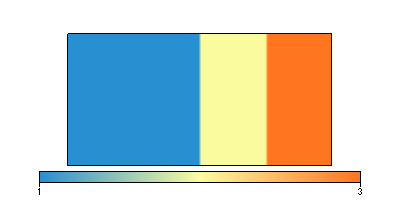

In [394]:
fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tg.mesh, pIdFn))
fig.show()

In [395]:
tg.undirected.neighbors(2)

[1, 3]

In [396]:
pAgeDict = tg.plate_age_fn() 

(1, (-1.0, 0.0), (0.0, 50.0))
(2, (0.0, 10.0), (0.5, 0.0))
(3, (0.5, 0.0), (1.0, 30.0))


In [397]:
pAgeDict

{0: <underworld.function.misc.constant at 0x7f554c065d90>,
 1: <underworld.function._function.add at 0x7f5547fbee90>,
 2: <underworld.function._function.add at 0x7f554c06d390>,
 3: <underworld.function._function.add at 0x7f554c06da50>}

In [398]:


fnAge_map = fn.branching.map(fn_key = pIdFn , 
                          mapping = pAgeDict )


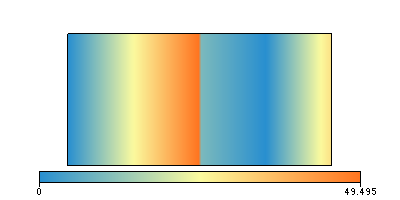

In [399]:
fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tg.mesh, fnAge_map))
fig.show()

FeMesh_IndexSet([4656, 4657, 4658, 4659, 4660, 4661, 4662, 4663, 4664, 4665, 4666,
       4667, 4668, 4669, 4670, 4671, 4672, 4673, 4674, 4675, 4676, 4677,
       4678, 4679, 4680, 4681, 4682, 4683, 4684, 4685, 4686, 4687, 4688,
       4689, 4690, 4691, 4692, 4693, 4694, 4695, 4696, 4697, 4698, 4699,
       4700, 4701, 4702, 4703, 4704, 4705, 4706, 4707, 4708, 4709, 4710,
       4711, 4712, 4713, 4714, 4715, 4716, 4717, 4718, 4719, 4720, 4721,
       4722, 4723, 4724, 4725, 4726, 4727, 4728, 4729, 4730, 4731, 4732,
       4733, 4734, 4735, 4736, 4737, 4738, 4739, 4740, 4741, 4742, 4743,
       4744, 4745, 4746, 4747, 4748, 4749, 4750, 4751, 4752])

Populating the interactive namespace from numpy and matplotlib


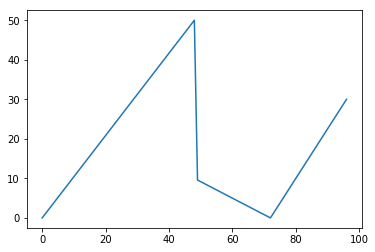

In [199]:
%pylab inline
plt.plot(fnAge_map.evaluate(mesh.specialSets['MaxJ_VertexSet']))

In [461]:
pId = 2



bounds  = np.sort(tg.get_boundaries(pId))

cond = operator.and_(szm.xFn >= bounds[0], szm.xFn <= bounds[1])
#cond =  szm.xFn > bounds[0]

plate_fn = fn.branching.conditional(  ( (cond,  1.),
                                              (        True, 0.)   ) )

dist = 0.061
cond1 = operator.or_(  fn.math.abs(bounds[0] - szm.xFn) <= dist, fn.math.abs(bounds[1] - szm.xFn) <= dist)

ridgeFn = fn.branching.conditional(  ( (cond1,  1.),
                                              (        True, 0.)   ) )

In [413]:
condList = []
for n in tg.nodes():
    bounds  = np.sort(tg.get_boundaries(n))
    
    edgetol = 1e-4
    if fn.math.abs(bounds[0] - szm.mesh.minCoord[0]) < edgetol:
        lb = bounds[0] - edgetol
    else:
        lb = bounds[0]

    if fn.math.abs(bounds[1] - szm.mesh.maxCoord[0]) > edgetol:
        ub = bounds[1] + edgetol
    else:
        ub = bounds[1]
    
    cond = operator.and_(szm.xFn >= lb, szm.xFn < ub)
    condList.append((cond, n))
condList.append((True, -99))

testFn = fn.branching.conditional( condList)

In [414]:
##test a mapping dictionary

testFn = fn.branching.conditional(  ( (szm.xFn > 0.5,  2),
                                              (        True, 1)   ) )

fn1 = fn.misc.constant(1.)
fn2 = fn.misc.constant(-1.)


map_dict = { 1:fn1,
              2:fn2}
# create function
fn_map = fn.branching.map( fn_key = testFn , 
                          mapping = map_dict )

In [415]:
def get_plate_bounds(tg, plateId):
    tg
    

In [416]:
plateId = 3

  

In [417]:
loc1, loc2
        

(0.5, 1.0)

In [418]:
loc1

0.5

In [419]:
#tg.out_edges(1), tg.in_edges(1),  
#tg.out_edges(2), tg.in_edges(2)

tg.out_edges(1), tg.in_edges(1)

([(1, 1), (1, 2)], [(1, 1)])

In [420]:
#tg.edge['A']['B']['loc']

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy
/usr/local/lib/python2.7/dist-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/usr/local/lib/python2.7/dist-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python2.7/dist-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axe

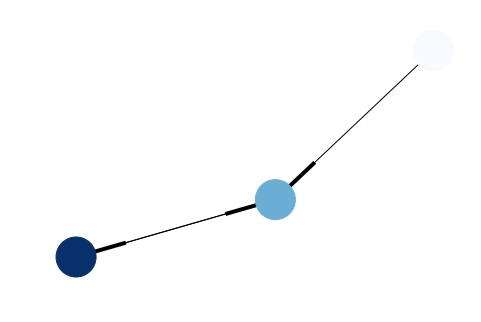

In [421]:
import pylab as plt
%pylab inline
nx.draw(tg,  node_size=1600, cmap=plt.cm.Blues,
        node_color=range(len(tg)),
        prog='dot')
plt.show()

## To do

* decide on what to do about `shadow plates'

* Plate velocity convention (no vels)
    * could be NaN
    
* Age model

## Scratch

In [30]:
G=nx.DiGraph()

In [31]:
G.add_node(1)
G.add_node(2)

In [32]:
G.add_edge(1,2)

G.add_edge(1,1)

In [33]:
G[1], G[2]

({1: {}, 2: {}}, {})

In [34]:
#G.add_edge(1, 'hey')

In [35]:
G.edges()

[(1, 1), (1, 2)]

In [36]:
G.nodes()

[1, 2]

In [37]:
print(G.nodes_with_selfloops())


[1]
